![lop](../../images/logo_diive1_128px.png)

<span style='font-size:28px; display:block;'>
<b>
    Calculate daytime flag, nighttime flag and potential radiation from latitude and longitude
</b>
</span>

---
**Notebook version**: `2` (23 Mar 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Description**

- Calculation of two flags for each record:
    - Daytime flag, where daytime=1 and nighttime=0
    - Nighttime flag, where daytime=0 and nighttime=1
- Both flags are calculated from potential radiation, whereby values below a specified threshold are nighttime
- Potential radiation is calculated from latitude and longitude

</br>

# **Imports**

In [1]:
import importlib.metadata
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from diive.configs.exampledata import load_exampledata_parquet
from diive.pkgs.createvar.daynightflag import DaytimeNighttimeFlag
from diive.core.plotting.heatmap_datetime import HeatmapDateTime

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.71.6


</br>

# **Docstring**

In [2]:
help(DaytimeNighttimeFlag)

Help on class DaytimeNighttimeFlag in module diive.pkgs.createvar.daynightflag:

class DaytimeNighttimeFlag(builtins.object)
 |  DaytimeNighttimeFlag(timestamp_index: pandas.core.indexes.datetimes.DatetimeIndex, utc_offset: int, lat: float, lon: float, nighttime_threshold: float = 50)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, timestamp_index: pandas.core.indexes.datetimes.DatetimeIndex, utc_offset: int, lat: float, lon: float, nighttime_threshold: float = 50)
 |      Calculate flags to identify daytime and nighttime data from potential radiation.
 |      
 |      Args:
 |          timestamp_index: Time series index, flags and potential radiation
 |              are calculated using this index
 |          utc_offset: UTC offset of *timestamp_index*, e.g. 1 for UTC+01:00
 |          lat: Latitude
 |          lon: Longitude
 |          nighttime_threshold: Threshold for potential radiation below which data
 |              are flagged as nighttime (W m-2)
 |      
 |      - Ex

</br>

</br>

# **Load example data**

In [3]:
df = load_exampledata_parquet()

Loaded .parquet file L:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.055 seconds). Detected time resolution of <30 * Minutes> / 30T 


In [4]:
df

,ET_f,GPP_CUT_16_f,GPP_CUT_84_f,GPP_CUT_REF_f,GPP_CUT_REF_fqc,GPP_DT_CUT_16,GPP_DT_CUT_84,GPP_DT_CUT_REF,GPP_DT_CUT_REF_SD,LE_f,LE_orig,LW_IN,NEE_CUT_16_f,NEE_CUT_16_orig,NEE_CUT_84_f,...,Reco_CUT_REF,Reco_DT_CUT_16,Reco_DT_CUT_84,Reco_DT_CUT_REF,Reco_DT_CUT_REF_SD,Rg_f,Rg_orig,RH,SWC_FF0_0.15_1,Tair_f,Tair_orig,Ustar_CUT_REF_fqc,Ustar_CUT_REF_Thres,VPD_f,VPD_orig
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:15:00,0.290134,0.509709,-0.082120,0.704570,1.0,0.0,0.0,0.0,0.0,13.092806,NaN,194.913214,1.376122,NaN,1.537436,...,2.300025,1.251884,1.907757,1.613003,0.509600,0.0,0.0,31.933333,34.976620,-1.618000,-1.618000,0.0,0.287644,1.339000,1.339000
2013-01-01 00:45:00,0.290130,0.511877,-0.083807,0.707522,1.0,0.0,0.0,0.0,0.0,13.092806,NaN,193.567693,1.376122,NaN,1.537436,...,2.302977,1.241100,1.913934,1.616019,0.512473,0.0,0.0,32.600000,34.976730,-1.630000,-1.630000,0.0,0.287644,1.337000,1.337000
2013-01-01 01:15:00,0.289530,0.513692,-0.085813,0.710022,1.0,0.0,0.0,0.0,0.0,13.065880,NaN,193.135202,1.376122,NaN,1.537436,...,2.305477,1.230092,1.919791,1.618733,0.515297,0.0,0.0,38.866667,34.971310,-1.644000,-1.644000,0.0,0.287644,1.335000,1.335000
2013-01-01 01:45:00,0.289526,1.354227,-0.087657,1.770620,0.0,0.0,0.0,0.0,0.0,13.065880,NaN,192.082736,0.537565,0.537565,1.537436,...,2.308185,1.219232,1.925787,1.621581,0.518213,0.0,0.0,37.766667,34.974970,-1.657000,-1.657000,0.0,0.287644,1.332000,1.332000
2013-01-01 02:15:00,0.376985,0.545335,-0.079582,0.796802,1.0,0.0,0.0,0.0,0.0,16.995263,NaN,192.677177,1.544471,NaN,1.709463,...,2.561882,1.346570,2.105211,1.790283,0.578416,0.0,0.0,39.533333,34.966570,-0.567000,-0.567000,1.0,0.287644,3.545000,3.545000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,-0.016362,0.372884,0.203050,0.599719,1.0,0.0,0.0,0.0,0.0,-0.734820,-0.73482,230.498649,0.628517,NaN,1.252629,...,1.823971,2.568115,1.221357,1.031544,0.758554,0.0,0.0,71.790000,19.571710,3.463333,3.463333,0.0,0.287644,2.210036,2.210036
2022-12-31 22:15:00,0.105363,-2.379376,0.893736,-1.433363,0.0,0.0,0.0,0.0,0.0,4.723780,4.72378,231.787766,3.517950,3.517950,0.802932,...,2.084587,2.959299,1.355551,1.173899,0.837950,0.0,0.0,62.626667,19.577070,5.283333,5.283333,0.0,0.287644,3.327497,3.327497
2022-12-31 22:45:00,0.219531,-0.515191,0.925969,-0.305039,1.0,0.0,0.0,0.0,0.0,9.839938,NaN,237.303455,1.672768,NaN,0.802932,...,2.119267,3.038077,1.366567,1.198887,0.857108,0.0,0.0,61.746667,19.588683,5.536667,5.536667,0.0,0.287644,3.466505,3.466505


</br>

</br>

# **Calculation of flags from potential radiation**

In [5]:
dnf = DaytimeNighttimeFlag(
    timestamp_index=df.index,
    nighttime_threshold=1,
    lat=47.286417,
    lon=7.733750,
    utc_offset=1
)

## Results

In [6]:
results = dnf.get_results()
results

,SW_IN_POT,DAYTIME,NIGHTTIME
TIMESTAMP_MIDDLE,,,
2013-01-01 00:15:00,0.0,0.0,1.0
2013-01-01 00:45:00,0.0,0.0,1.0
2013-01-01 01:15:00,0.0,0.0,1.0
2013-01-01 01:45:00,0.0,0.0,1.0
2013-01-01 02:15:00,0.0,0.0,1.0
...,...,...,...
2022-12-31 21:45:00,0.0,0.0,1.0
2022-12-31 22:15:00,0.0,0.0,1.0
2022-12-31 22:45:00,0.0,0.0,1.0


In [7]:
dnf.get_swinpot()

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.0
2013-01-01 00:45:00    0.0
2013-01-01 01:15:00    0.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30T, Name: SW_IN_POT, Length: 175296, dtype: float64

In [8]:
dnf.get_daytime_flag()

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.0
2013-01-01 00:45:00    0.0
2013-01-01 01:15:00    0.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    0.0
                      ... 
2022-12-31 21:45:00    0.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    0.0
2022-12-31 23:15:00    0.0
2022-12-31 23:45:00    0.0
Freq: 30T, Name: DAYTIME, Length: 175296, dtype: float64

In [9]:
dnf.get_nighttime_flag()

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    1.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    1.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    1.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30T, Name: NIGHTTIME, Length: 175296, dtype: float64

</br>

</br>

# **Plot some variables**

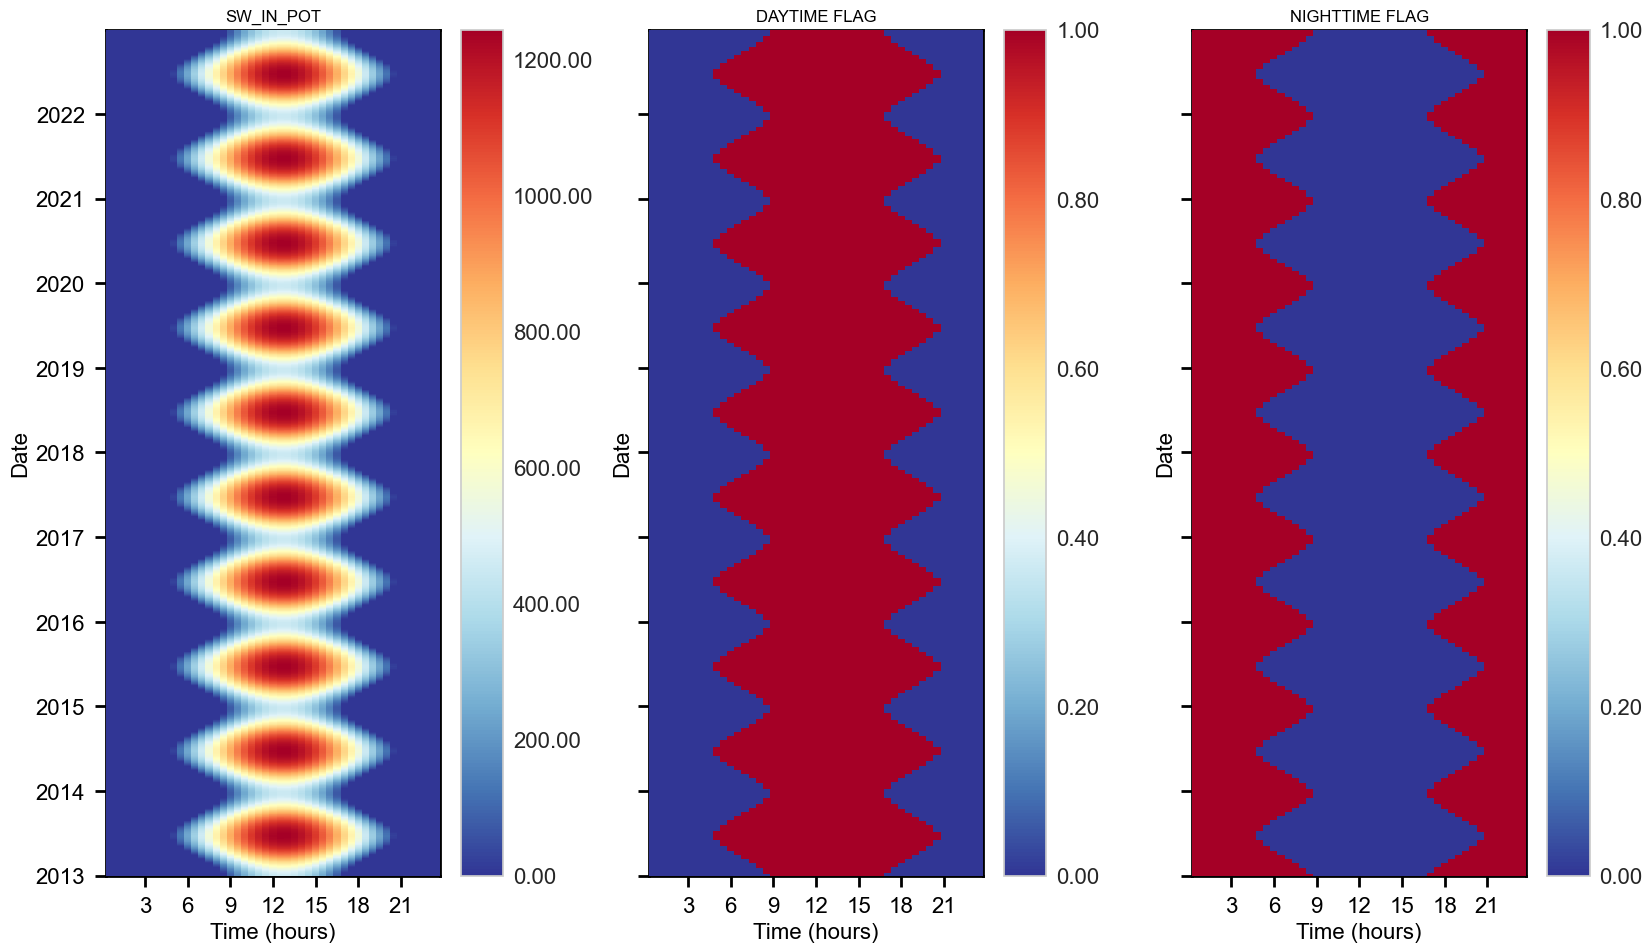

In [10]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
gs.update(wspace=0.3, hspace=0.3, left=0.03, right=0.97, top=0.97, bottom=0.03)
ax_sw = fig.add_subplot(gs[0, 0])
ax_dt = fig.add_subplot(gs[0, 1])
ax_nt = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_sw, series=dnf.get_swinpot()).plot()
HeatmapDateTime(ax=ax_dt, series=dnf.get_daytime_flag()).plot()
HeatmapDateTime(ax=ax_nt, series=dnf.get_nighttime_flag()).plot()
ax_sw.set_title("SW_IN_POT", color='black')
ax_dt.set_title("DAYTIME FLAG", color='black')
ax_nt.set_title("NIGHTTIME FLAG", color='black')
ax_dt.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_nt.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)

</br>

# **End of notebook**

In [11]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-03-22 23:40:48
